
Neural networks are known to "trick" us by exploiting unobvious shortcuts to achieve good performance (e.g., when tasked with recognizing if a wolf or a dog is on the image, they could learn to recognize the features of terrain instead).  Convolutional Neural Networks (CNN) are extremely useful in image classification tasks. They recognize patterns in the data by encoding various features in the images such as edges, lines, circles.
We hope a neural network to depend solely on pixels it sees, but... position information might be useful as well.

Can a CNN recover information about the position of each pixel just from pixel values and padding? In this task, you will verify this hypothesis.

You have to implement a CNN model which will predict the position of each pixel (the x or y coordinate normalized to [0,1]) using convolutional layers.



The ideal model would output something like this: 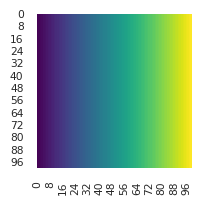

In [1]:
import torch.nn.functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


# Implement SimpleConvnet (5p)
This model consist of two parts:
- a parametrized number of blocks
- linear projection

Each block should have two layers: *convolution* and *relu*. The number of blocks is parametrized by the **n_convolutions** argument. All convolutions layers **in blocks** should have a kernel_size equal to 3 and padding equal to 1.

The input to the model has the shape: (batch_size, 1, spatial_dimension, spatial_dimension), so it starts with only 1 channel (filter). First 4 blocks should double the number of channels. Blocks from index 4 upward should keep the number of channels (filters) unchanged.

Linear projection should decrease the number of channels to 1. Therefore, the output of the model should match the input in shape.

In [3]:
min(22, 4)

4

In [4]:
class SimpleConvnet(nn.Module):
    def __init__(self, n_convolutions):
        super(SimpleConvnet, self).__init__()
        # TODO
        l = []
        n_chanels = 1
        for i in range(min(4, n_convolutions)):
          l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = (2*n_chanels), kernel_size = 3, padding=1, bias=True))
          l.append(nn.ReLU())
          n_chanels = n_chanels * 2
        for i in range(n_convolutions - 4):
          l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = n_chanels, kernel_size = 3, padding=1, bias=True))
          l.append(nn.ReLU())

        l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = 1, kernel_size = 1, padding=0, bias=True))

        self.net = nn.Sequential(*l)
        # END TODO


    def forward(self, x):
      # TODO
      return self.net(x)
      # END TODO


## Helper functions

In [8]:
def visualize(array):
  plt.figure(figsize=(2,2))
  sns.set(font_scale=0.7)
  sns.heatmap(array, cmap='viridis', cbar=False, annot=False)
  plt.show()

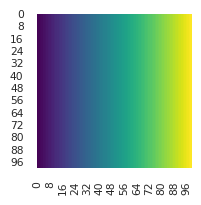

In [6]:
def generate_spectrum(spatial_dimension):
  row = torch.linspace(0, 1, spatial_dimension)
  return row.expand(spatial_dimension, -1)
spectrum = generate_spectrum(100)
visualize(spectrum.numpy())

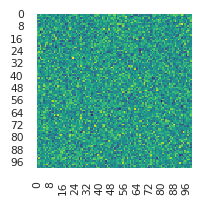

In [9]:
def generate_noise(batch_size, spatial_dimension):
  return torch.randn(batch_size, 1, spatial_dimension, spatial_dimension)
visualize(generate_noise(1,100)[0].squeeze().numpy())

## Training (1p)
Implement target preparation.

In [12]:
batch_size = 2
spatial_dimension = 5

row = torch.linspace(0, 1, spatial_dimension)
row = row.expand(batch_size, 1, spatial_dimension, -1)
print(row.shape)

torch.Size([2, 1, 5, 5])


In [13]:
def train(epochs, steps, batch_size, model, optimizer, spatial_dimension, verbose=1):
    model.train()

    # TODO
    # Prepare target (it will be the same in every sample)
    row = torch.linspace(0, 1, spatial_dimension)
    target = row.expand(batch_size, 1, spatial_dimension, -1)


    # ENDTODO
    assert target.shape == torch.Size([batch_size, 1, spatial_dimension, spatial_dimension])

    for epoch in range(epochs):
        running_loss = 0
        for i in range(steps):
            noise = generate_noise(batch_size, spatial_dimension)
            predicted = model(noise)
            loss = F.mse_loss(predicted, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose > 0:
          print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, running_loss / steps))
          with torch.no_grad():
            input = generate_noise(1, spatial_dimension)
            predicted_gradient = model(input)[0].numpy()
            visualize(predicted_gradient.squeeze(0))

In [ ]:
# Check if training works
# do not exceed n_convolutions = 10 and spatial_dimension = 20
n_convolutions = 6#  TODO
spatial_dimension = 5 # TODO
epochs = 20
steps = 50

model = SimpleConvnet(n_convolutions)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=1)

## Experiments (5p)

Create two lists:
- *n_convolutions_params* with 4 different values (suggested [2, 4, 6, 8])
- *spatial_dimensions_params* with 4 different values (suggested [5,10,15,20])

For each pair (n_convolutions,spatial_dimensions) $\in$ (n_convolutions_params $\times$ spatial_dimensions_param), train a model with these parameters and visualize the prediction of the trained model on a sampled noise.

Represent these vizualizations on image grid of shape 4 $\times$ 4. Explain these results.

(Note: do not exceed n_convolutions = 10 and spatial_dimension = 20. It takes about 2min on CPU to train model with these parameters. )

(Note2: *visualize* function runs plt.show() so it can interfere with image grid. You can disable it by changing verbose argument in *train* to 0.)


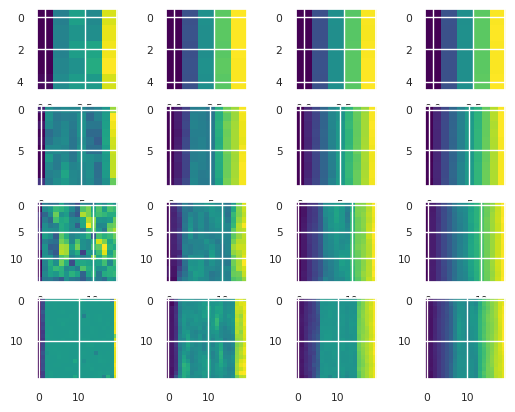

In [39]:
epochs = 20
steps = 50
batch_size = 256

# n_convolutions_params = [2, 4]
# spatial_dimensions_params = [4, 6]
n_convolutions_params = [2, 4, 6, 8]
spatial_dimensions_params = [5,10,15,20]

dim1 = len(n_convolutions_params)
dim2 = len(spatial_dimensions_params)

fig, axs = plt.subplots(dim1, dim2)


for j in range(len(n_convolutions_params)):
  for i in range(len(spatial_dimensions_params)):
    # model = SimpleConvnet(2)
    model = SimpleConvnet(n_convolutions_params[j])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(epochs, steps, batch_size, model, optimizer, spatial_dimensions_params[i], verbose=0)


    with torch.no_grad():
      input = generate_noise(1, spatial_dimensions_params[i])
      predicted_gradient = model(input)[0].numpy()

      axs[i][j].imshow(predicted_gradient.squeeze(0), cmap='viridis')


plt.show()

# horizontal axis -> number of convolutions increases to the right
# veertical axis -> number of pixels increses down

In [40]:
class SimpleConvnet(nn.Module):
    def __init__(self, n_convolutions):
        super(SimpleConvnet, self).__init__()
        # TODO
        l = []
        n_chanels = 1
        for i in range(min(4, n_convolutions)):
          l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = (2*n_chanels), kernel_size = 3, padding=1, bias=True, padding_mode = 'circular'))
          l.append(nn.ReLU())
          n_chanels = n_chanels * 2
        for i in range(n_convolutions - 4):
          l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = n_chanels, kernel_size = 3, padding=1, bias=True, padding_mode = 'circular'))
          l.append(nn.ReLU())

        l.append(torch.nn.Conv2d(in_channels = n_chanels, out_channels = 1, kernel_size = 1, padding=0, bias=True))

        self.net = nn.Sequential(*l)
        # END TODO


    def forward(self, x):
      # TODO
      return self.net(x)
      # END TODO


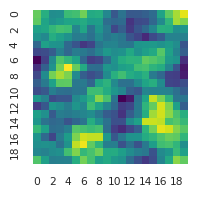

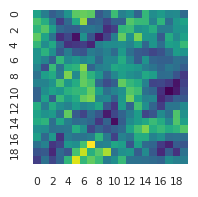

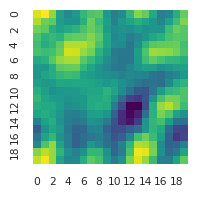

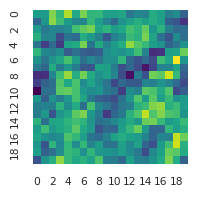

In [42]:
# additional experiment:

n_convolutions = 6#  TODO
spatial_dimension = 5 # TODO
epochs = 20
steps = 50
for i in range(4):
  model = SimpleConvnet(n_convolutions)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=0)
  with torch.no_grad():
      input = generate_noise(1, spat_dim)
      predicted_gradient = model(input)[0].numpy()
      visualize(predicted_gradient.squeeze(0))

The thing that breaks the symmetry is the padding -otherwise each pixel is sampled from the same distribution - but the pixels at the edges - the padded ones are equal to zero (unless the padding_mode is changed) so the model retrieves the spatial information from the padding. Because of that only some pixels in the further layers can know what positions they have - those that were close enough to the padding to have been created using padding - ie padding pixels from the previous layers were 'touched by' the filters in the process of making them. So given that the stride is one, this information can flow thrugh the layers from edges further into the inside of the image slowly -> kernel_size//2 pixels per layer - so in this case one pixel per layer.
Because the information that is sought after is the x coordinate, the pixels can retrieve it by the propagation through layers the 'information' from padding on the vertical edges of the picture (probably starting only from pixels after 1st layer as those in the inside can be quite easily set to sth != 0, and the added padding (in the 2nd layer) would be equal 0) so a certain number of convolutions is needed so as to spread this information through the whole image (about a half of the spatial_dimension in this setting).
Other output pixels that couldn't have got that information from padding because they are too far from the vertical edges are set to the most neutral color -> a mean of the colors at the vertical edges, so 0.5 = (0+1)/2, so as to minimise as much as possible the loss.
To support my claim I ran another experiment with different padding_mode set - circular one. It confirms my suspicions as the model was unable to learn anything meaningful.
Also the grid experiment supports my reasoning -> generally the pixels close to the vertical edges have colors very close to perfect ones. But only if they are not so far and this distance increases linearly with the number of convolutions as can be seen. Also the size of the light blue color (in the middle) in the output decreases with the number of convolutions.
With enough convolutions to propagate the information from the vertical edges the output images are very good, furthermore further increases of the number of convolutions don't provide a lot improvement (as the images are already very good).

In [ ]:
#here the images are more beautiful but not in the grid:

#TODO
epochs = 20
steps = 50
batch_size = 256

n_convolutions_params = [2, 4, 6, 8]
spatial_dimensions_params = [5,10,15,20]

for n_conv in n_convolutions_params:
  for spat_dim in spatial_dimensions_params:
    model = SimpleConvnet(n_conv)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(epochs, steps, batch_size, model, optimizer, spat_dim, verbose=0)

    with torch.no_grad():
      input = generate_noise(1, spat_dim)
      predicted_gradient = model(input)[0].numpy()
      visualize(predicted_gradient.squeeze(0))

# END TODO